In [2]:
#Import all needed files
import csv
import sys, os, re
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, find_peaks

import warnings

In [9]:
#Import trial data

if os.uname().sysname == 'Darwin':
    # macOS detected
    print("Running on macOS")
    file_path = "/Users/kaanborekci/Library/CloudStorage/OneDrive-NorthwesternUniversity/BME_390-1_Phrenic_Nerve/QUARTER 3/Data Analysis Code/Jay_Quarter2_Trial.csv"
else:
    # Not macOS
    print("Running on another OS")
    file_path = r"C:\Users\jgx7497\Documents\BME 390-3\Jay_Quarter2_Trial(in).csv"

df = pd.read_csv(file_path)
df

Running on macOS


,Time(ms),Acc_x(g),Acc_y(g),Acc_z(g),Gyro_x,Gyro_y,Gyro_z,CO2(ppm)
0,226922,-0.190,1.002,0.117,13.611,25.282,-1.489,0
1,226932,-0.207,1.021,0.167,15.832,19.794,1.511,0
2,226942,-0.198,1.056,0.142,10.084,10.550,2.763,0
3,226964,-0.192,1.001,0.160,-1.374,-1.252,1.618,0
4,226964,0.000,0.000,0.000,0.000,0.000,0.000,1148
...,...,...,...,...,...,...,...,...
35443,585922,0.047,0.940,0.263,0.962,0.053,-0.450,0
35444,585932,0.044,0.934,0.259,1.443,0.435,-0.382,0
35445,585942,0.042,0.939,0.273,1.015,-0.260,-0.412,0
35446,585965,0.020,0.940,0.287,-0.053,-0.626,-0.832,0


In [10]:
# Read the CSV into a DataFrame.
df = pd.read_csv(file_path)
    
# Define the required columns.
required_cols = ['Time(ms)', 'Acc_x(g)', 'Acc_y(g)', 'Acc_z(g)',
                 'Gyro_x', 'Gyro_y', 'Gyro_z', 'CO2(ppm)']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError("Missing required columns: " + ", ".join(missing_cols))


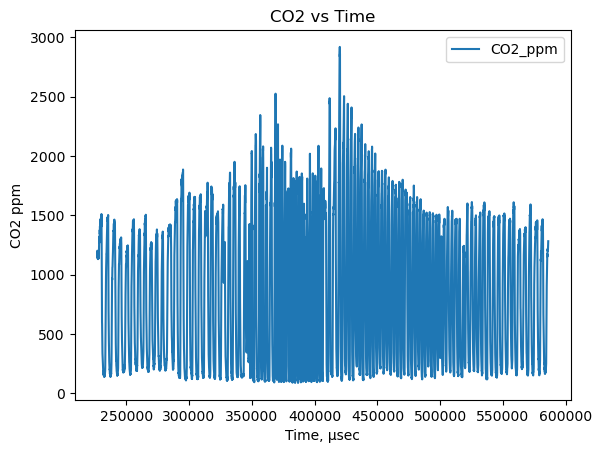

In [16]:
#Identify the accel/gyro rows and CO2 rows respectively
co2_rows = df[df['CO2(ppm)'] != 0].copy()
sensor_rows = df[(df[['Acc_x(g)', 'Acc_y(g)', 'Acc_z(g)', 'Gyro_x', 'Gyro_y', 'Gyro_z']] != 0).any(axis=1)].copy()
#Define tolerance in ms
tolerance = 5
merged_rows = []

#Prepare an empty list to collecte the merged rows
for idx, co2_row in co2_rows.iterrows():
    #Find sensor rows within +/- 3 ms
    mask = (sensor_rows["Time(ms)"] >= co2_row["Time(ms)"] - tolerance) & (sensor_rows['Time(ms)'] <= co2_row['Time(ms)'] + tolerance)
    nearby_sensors = sensor_rows[mask]

    if not nearby_sensors.empty:
        best_sensor = nearby_sensors.iloc[(nearby_sensors['Time(ms)'] - co2_row['Time(ms)']).abs().argsort()].iloc[0]
        # Merge the two rows into one
    merged_row = {
        'Time(ms)': co2_row['Time(ms)'],
        'Acc_x(g)': best_sensor['Acc_x(g)'],
        'Acc_y(g)': best_sensor['Acc_y(g)'],
        'Acc_z(g)': best_sensor['Acc_z(g)'],
        'Gyro_x': best_sensor['Gyro_x'],
        'Gyro_y': best_sensor['Gyro_y'],
        'Gyro_z': best_sensor['Gyro_z'],
        'CO2(ppm)': co2_row['CO2(ppm)']
    }
    merged_rows.append(merged_row)

merged_df = pd.DataFrame(merged_rows)

plt.figure()
plt.title("CO2 vs Time")
plt.plot(merged_df["Time(ms)"], merged_df["CO2(ppm)"], label="CO2_ppm")
plt.legend()
plt.xlabel("Time, µsec")
plt.ylabel("CO2 ppm")
plt.show()

In [26]:
def give_peaks(times, signal):
    """ This helper function will find the peaks of a signal
    Args:
        times - array of time values
        signal - singal to find peaks of
    Returns:
        peak_locations - locations of peaks
        peak_values - values of peaks
    """
    peak_locations = []
    peak_values = []

    #Cast dataframes into a list
    times = list(times)
    signal = list(signal)

    #Know the distance by which to separate peaks by
    sampling_rate_hz = 20 #The SPRINTIR-WF-20 samples at 20 hz
    time_per_breath_s = 4 #assuming that the fastest someone would breathe is 4 seconds per breath
    distance_between_peaks = sampling_rate_hz * time_per_breath_s


    #Use scipy to find the peaks
    peaks, dict = find_peaks(signal, distance=10, prominence=300)
    for peak in peaks:
        peak_locations.append(times[peak])
        peak_values.append(signal[peak])

    return peak_locations, peak_values


In [34]:
def find_breathing_rate(times, co2_signal):
    """Finds the breathing rate for any subset of data
    Args:
        times - array of time values
        co2_signal - array of co2 signal
    Returns:
        breathing_rate - breathing rate in bpm
    """
    peaks, values = give_peaks(times, co2_signal)
    num_breaths_total = len(peaks)
    
    #Convert from time (ms) to time (min)
    total_time_ms = times.iloc[-1] - times.iloc[0]
    total_time_minutes = total_time_ms / (1000*60)

    #Calculate and return breathing rate
    breathing_rate = num_breaths_total / total_time_minutes
    return breathing_rate

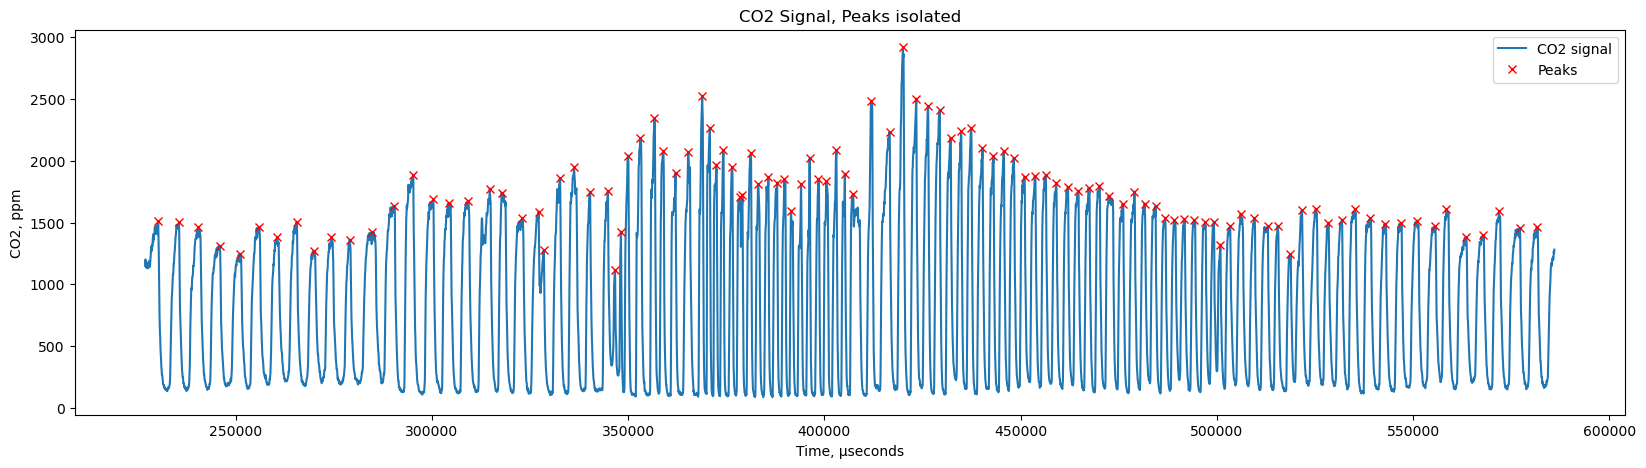

In [ ]:

#"""Plots the co2 sensor signal along with the peaks"""
#Plotting peaks of the signals

time = merged_df["Time(ms)"].astype('Int64')
co2_signal = merged_df["CO2(ppm)"].astype('Int64')

co2_peak_locs, co2_peak_values = give_peaks(time, co2_signal)
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time,co2_signal, label="CO2 signal")
plt.plot(co2_peak_locs, co2_peak_values, 'rx', label='Peaks')
plt.xlabel("Time, µseconds")
plt.ylabel("CO2, ppm")
plt.title("CO2 Signal, Peaks isolated")
plt.legend()
plt.show()

In [146]:
co2_peak_locs

[1.056,
 3.597,
 7.07,
 10.549,
 14.299,
 18.427,
 23.307,
 27.737,
 31.527,
 34.976,
 40.015,
 45.125,
 48.597,
 51.507,
 53.899,
 55.711,
 57.985,
 60.784,
 63.591,
 66.451,
 69.349,
 73.302,
 76.724,
 79.6,
 81.862,
 84.688,
 87.205,
 89.501,
 92.201,
 94.833,
 96.924,
 99.215,
 101.715,
 104.806,
 107.201,
 109.653,
 111.669,
 114.122,
 116.165,
 118.11,
 120.173,
 122.116,
 123.5,
 125.435,
 126.832,
 128.146,
 129.323,
 131.044,
 132.688,
 134.152,
 136.125,
 137.706,
 139.246,
 141.01,
 142.789,
 145.018,
 146.849,
 150.324,
 151.803,
 153.125,
 154.464,
 156.097,
 157.706,
 158.747,
 159.487,
 161.165,
 163.776,
 165.706,
 167.44,
 169.423,
 171.208,
 173.061,
 174.857,
 176.626,
 178.451,
 179.828,
 181.349,
 183.222,
 185.001,
 187.508,
 189.844,
 193.255,
 196.44,
 200.437,
 204.294,
 208.24,
 211.432,
 214.062,
 217.983,
 220.102,
 223.292,
 227.461,
 231.117,
 233.635,
 236.336,
 239.265,
 242.773,
 246.312,
 249.682,
 252.393,
 255.011,
 257.68,
 261.367,
 261.969,
 265.1

In [ ]:

diff=time[20]-time[19] #0.050 seconds 
diff
# 1/(diff)


co2_signal[20]


3130.0

In [135]:
# Calculate differences between consecutive points
differences = [((time[i+1] - time[i]) * 1000) for i in range(1, len(time)-1)]

differences

[50.99999999999999,
 51.000000000000014,
 47.999999999999986,
 49.999999999999986,
 51.00000000000004,
 50.99999999999999,
 48.999999999999986,
 52.00000000000004,
 48.99999999999993,
 51.00000000000004,
 50.999999999999936,
 50.00000000000004,
 49.00000000000004,
 49.999999999999936,
 52.00000000000004,
 48.99999999999993,
 49.999999999999936,
 49.000000000000156,
 137.9999999999999,
 52.00000000000004,
 50.00000000000004,
 48.00000000000004,
 50.999999999999936,
 50.00000000000004,
 52.00000000000004,
 49.99999999999982,
 51.000000000000156,
 47.99999999999982,
 53.000000000000156,
 50.999999999999936,
 48.99999999999993,
 50.00000000000004,
 50.00000000000004,
 50.999999999999936,
 50.00000000000004,
 49.99999999999982,
 49.00000000000038,
 254.9999999999999,
 50.999999999999716,
 50.00000000000027,
 49.99999999999982,
 50.00000000000027,
 50.999999999999716,
 48.99999999999993,
 51.000000000000156,
 51.000000000000156,
 48.99999999999993,
 49.99999999999982,
 52.00000000000004,
 48

## BLOM Trial - Q1

In [77]:
def txt_to_df(txt_path, column_names):

    '''
    Description: Function takes the data written onto the txt file and creates a pandas DataFrame matrix.
    - Make sure that the final column is CO2, and also check that all the column names match the appropriate data.
    '''

    # Open and read txt file information into a string
    with open(txt_path, 'r') as txt_open:
        txt = txt_open.read()

    # Remove commas from string containing txt file info, then split to a list individual strings
    txt_data = txt.replace(",","").split()

    # Initialize a dictionary that will later be converted to DataFrame (df)
    df_dict = {key: [] for key in column_names}

    # Loop through the txt data and place each variable in respective column in initialized dictionary
    for i, item in enumerate(txt_data):

        # Create a modified index that reinitializes to 0 after overflowing from the final column
        key_index = i % len(column_names)

        # Place each data point into appropriate column and scale down by a factor of 1000
        df_dict[column_names[key_index]].append(int(item)/1000) # Had multiplied by 1000 (except CO2) in data collection to reduce floating point math

    # Create pandas dataframe
    df = pd.DataFrame(df_dict, columns = column_names)

    # Multiply last column (CO2) back by 1000 to get original value
    if df.columns[-1] == 'CO2':
        df.iloc[:, -1] = df.iloc[:, -1] * 1000
    else:
        raise ValueError("The last column in the DataFrame is not named 'CO2'. Please check the column names.")

    return df

In [82]:
blom_path = "/Users/kaanborekci/Library/CloudStorage/OneDrive-NorthwesternUniversity/BME_390-1_Phrenic_Nerve/QUARTER 3/Data Analysis Code/241203_BlomTrial_SubjectJ_PNS/blomtrial.txt"
names = ['time',
         'a_x',
         'a_y',
         'a_z',
         'CO2']
df_blom = txt_to_df(blom_path, names)

In [83]:
df_blom

,time,a_x,a_y,a_z,CO2
0,0.014,-0.191,9.345,1.378,2350.0
1,0.153,-0.153,9.576,1.494,2640.0
2,0.204,-0.268,9.500,1.148,2760.0
3,0.255,-0.306,9.537,1.416,2800.0
4,0.303,-0.382,9.537,1.302,2960.0
...,...,...,...,...,...
6376,357.553,0.000,9.270,1.991,6810.0
6377,357.602,0.000,9.230,2.106,6920.0
6378,357.653,0.037,9.613,2.144,7200.0
6379,357.705,-0.037,9.384,1.761,7080.0


In [87]:
def give_peaks2(times, signal):
    """ This helper function will find the peaks of a signal
    Args:
        times - array of time values
        signal - singal to find peaks of
    Returns:
        peak_locations - locations of peaks
        peak_values - values of peaks
    """
    peak_locations = []
    peak_values = []

    #Cast dataframes into a list
    times = list(times)
    signal = list(signal)

    #Know the distance by which to separate peaks by
    sampling_rate_hz = 20 #The SPRINTIR-WF-20 samples at 20 hz
    time_per_breath_s = 4 #assuming that the fastest someone would breathe is 4 seconds per breath
    distance_between_peaks = sampling_rate_hz * time_per_breath_s


    #Use scipy to find the peaks
    peaks, dict = find_peaks(signal, distance=10, prominence=500)
    for peak in peaks:
        peak_locations.append(times[peak])
        peak_values.append(signal[peak])

    return peak_locations, peak_values

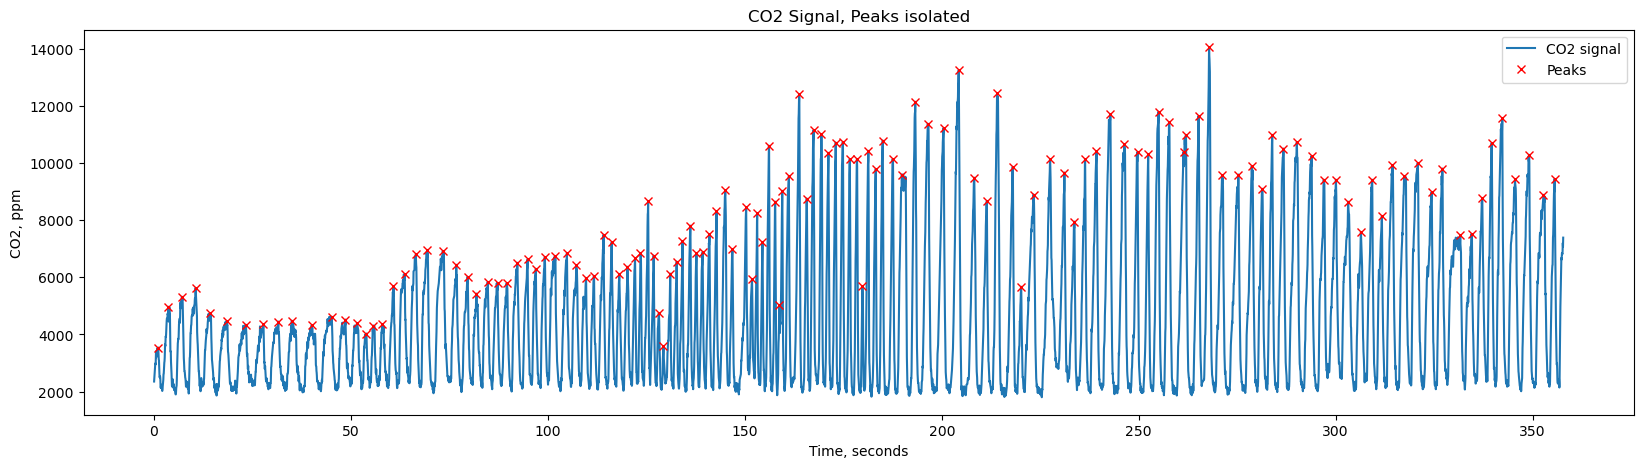

In [171]:
#"""Plots the co2 sensor signal along with the peaks"""
#Plotting peaks of the signals

time = df_blom["time"]
co2_signal = df_blom["CO2"]

co2_peak_time, co2_peak_values = give_peaks2(time, co2_signal)
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time,co2_signal, label="CO2 signal")
plt.plot(co2_peak_time, co2_peak_values, 'rx', label='Peaks')
plt.xlabel("Time, seconds")
plt.ylabel("CO2, ppm")
plt.title("CO2 Signal, Peaks isolated")
plt.legend()
plt.show()

In [184]:
peak_to_peak_time_diff = co2_peak_time[3]-co2_peak_time[2]

breathing_frequency_Hz = 1/peak_to_peak_time_diff

bpm = breathing_frequency_Hz * 60

print(f"{co2_peak_time[3]}sec minus {co2_peak_time[2]} sec -> {peak_to_peak_time_diff} seconds between peaks, {breathing_frequency_Hz} in Hz, {bpm} bpm")

10.549sec minus 7.07 sec -> 3.478999999999999 seconds between peaks, 0.28743891922966375 in Hz, 17.246335153779825 bpm


In [178]:
diff=time[400]-time[399] #0.050 seconds 
diff
# 1/(diff)

0.04899999999999949

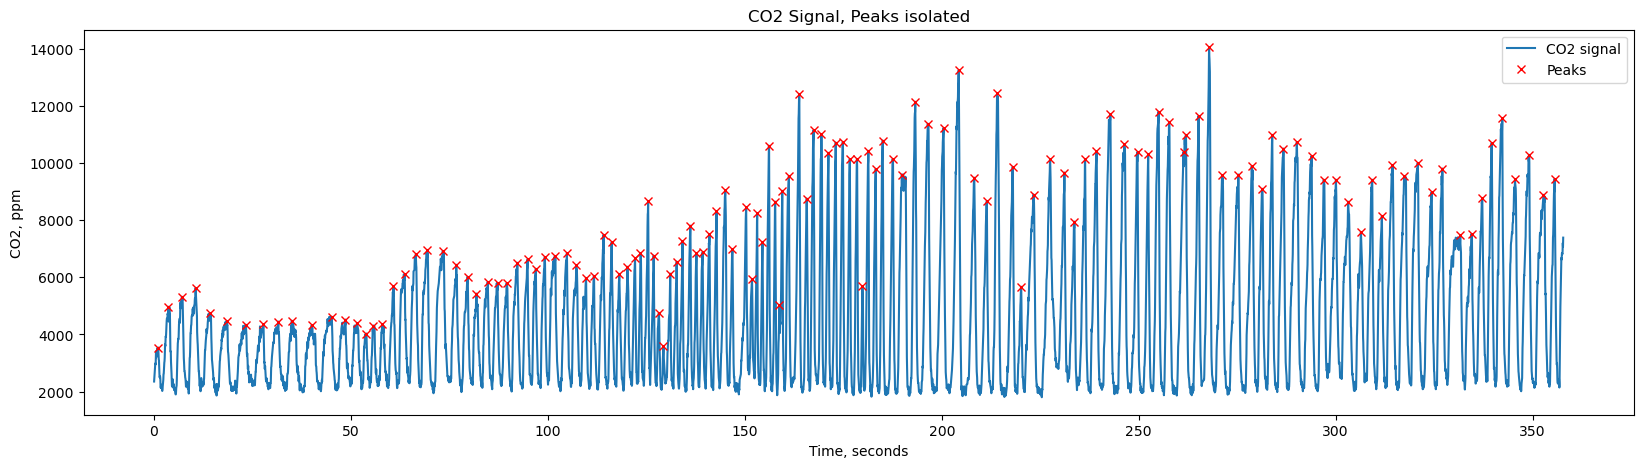

In [163]:
peak_locations = []
peak_values = []

#Cast dataframes into a list
time = df_blom["time"]
co2_signal = df_blom["CO2"]

#Use scipy to find the peaks
peaks, dict = find_peaks(co2_signal, distance=10, prominence=500)
for peak in peaks:
    peak_locations.append(time[peak])
    peak_values.append(co2_signal[peak])

peak_locations, peak_values = give_peaks2(time, co2_signal)
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time,co2_signal, label="CO2 signal")
plt.plot(peak_locations, peak_values, 'rx', label='Peaks')
plt.xlabel("Time, seconds")
plt.ylabel("CO2, ppm")
plt.title("CO2 Signal, Peaks isolated")
plt.legend()
plt.show()

In [164]:
for peak in peaks:
    print(time[peak])

1.056
3.597
7.07
10.549
14.299
18.427
23.307
27.737
31.527
34.976
40.015
45.125
48.597
51.507
53.899
55.711
57.985
60.784
63.591
66.451
69.349
73.302
76.724
79.6
81.862
84.688
87.205
89.501
92.201
94.833
96.924
99.215
101.715
104.806
107.201
109.653
111.669
114.122
116.165
118.11
120.173
122.116
123.5
125.435
126.832
128.146
129.323
131.044
132.688
134.152
136.125
137.706
139.246
141.01
142.789
145.018
146.849
150.324
151.803
153.125
154.464
156.097
157.706
158.747
159.487
161.165
163.776
165.706
167.44
169.423
171.208
173.061
174.857
176.626
178.451
179.828
181.349
183.222
185.001
187.508
189.844
193.255
196.44
200.437
204.294
208.24
211.432
214.062
217.983
220.102
223.292
227.461
231.117
233.635
236.336
239.265
242.773
246.312
249.682
252.393
255.011
257.68
261.367
261.969
265.169
267.851
271.137
275.302
278.682
281.413
283.894
286.708
290.11
293.859
296.974
300.054
303.141
306.401
309.224
311.731
314.36
317.406
320.813
324.391
327.052
331.615
334.485
337.184
339.571
342.293
345.515


# This section is the best:

Main Kaan additions

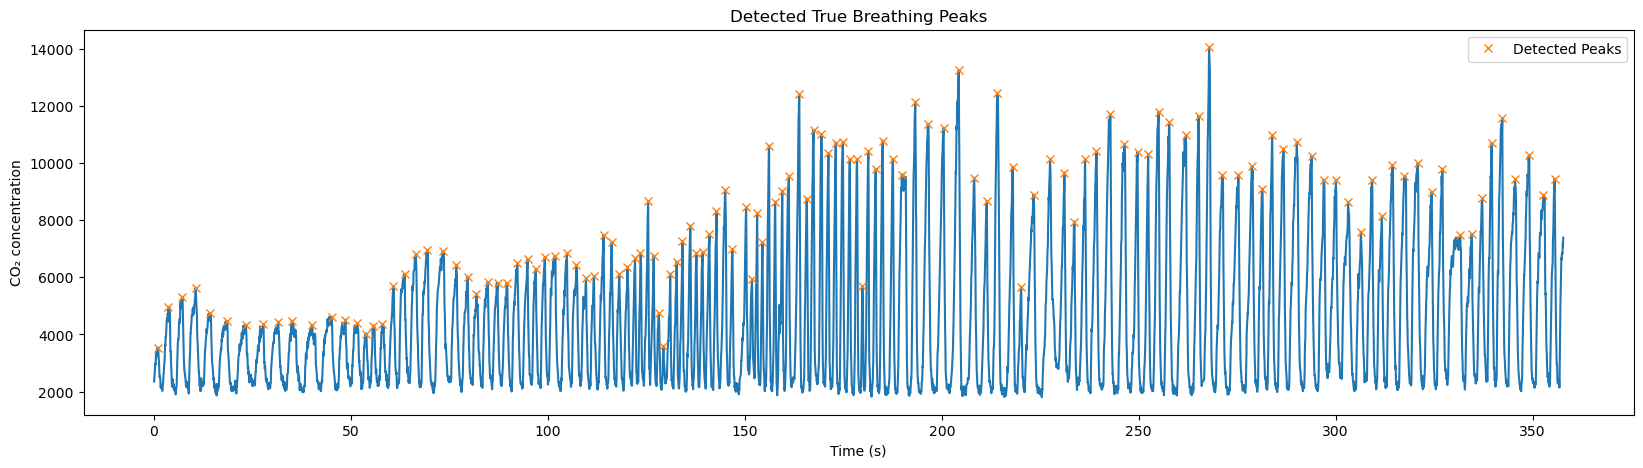

Global BPM: 22.14


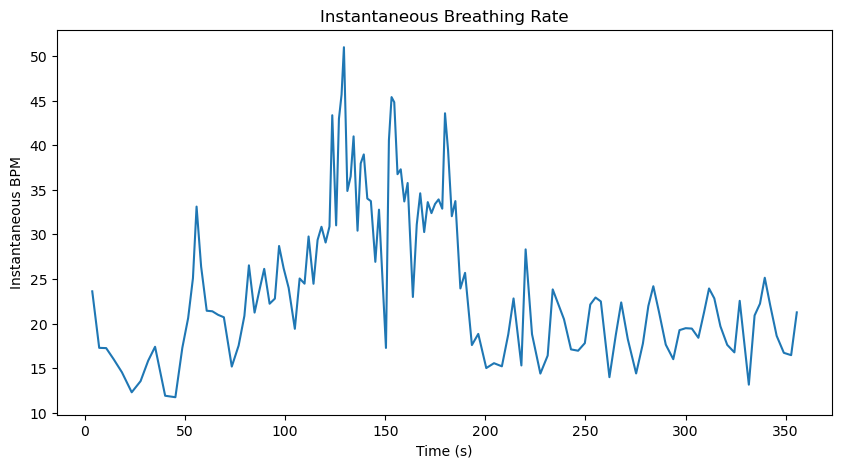

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming your dataframe is already loaded as:
# co2_df['time'] --> time in seconds
# co2_df['co2']  --> CO2 concentration
time = df_blom["time"]
co2_signal = df_blom["CO2"]

# 1. Detect Peaks directly on the raw CO2 signal, now with prominence
prominence_value = 1000  # Adjust this based on your data
peaks, _ = find_peaks(co2_signal, distance=20, prominence=prominence_value)
# distance = 20 samples = 1 second minimum between peaks at 20 Hz

# 2. Plot to verify peak detection
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time, co2_signal)
plt.plot(time.iloc[peaks], co2_signal.iloc[peaks], "x", label="Detected Peaks")
plt.xlabel('Time (s)')
plt.ylabel('CO₂ concentration')
plt.title('Detected True Breathing Peaks')
plt.legend()
plt.show()

# 3. Calculate Global BPM (breaths per minute)
total_time_minutes = (time.iloc[-1] - time.iloc[0]) / 60
total_breaths = len(peaks)
bpm_global = total_breaths / total_time_minutes
print(f"Global Breaths per Minute: {bpm_global:.2f}")

# 4. Calculate Instantaneous BPM (optional)
peak_times = time.iloc[peaks].values
intervals_sec = np.diff(peak_times)  # time between peaks (seconds)
instantaneous_bpm = 60 / intervals_sec  # convert to bpm

# Plot instantaneous BPM (optional)
plt.figure(figsize=(10,5))
plt.plot(peak_times[1:], instantaneous_bpm)
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous Breaths per Minute')
plt.title('Instantaneous Breathing Rate')
plt.show()


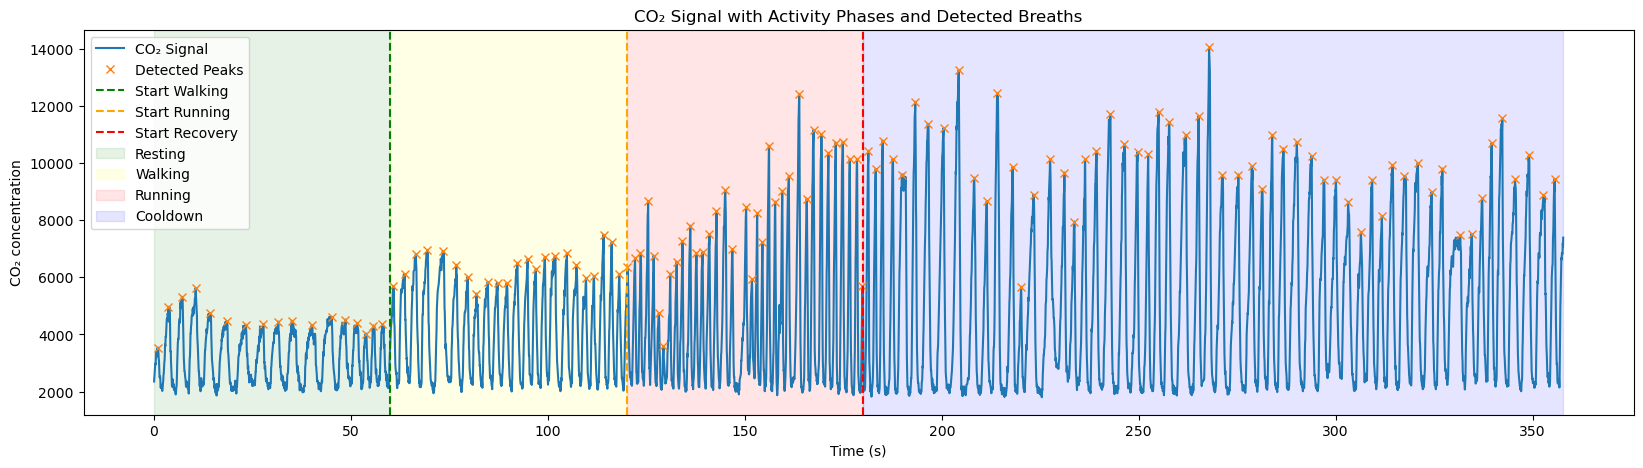

Global BPM: 22.14


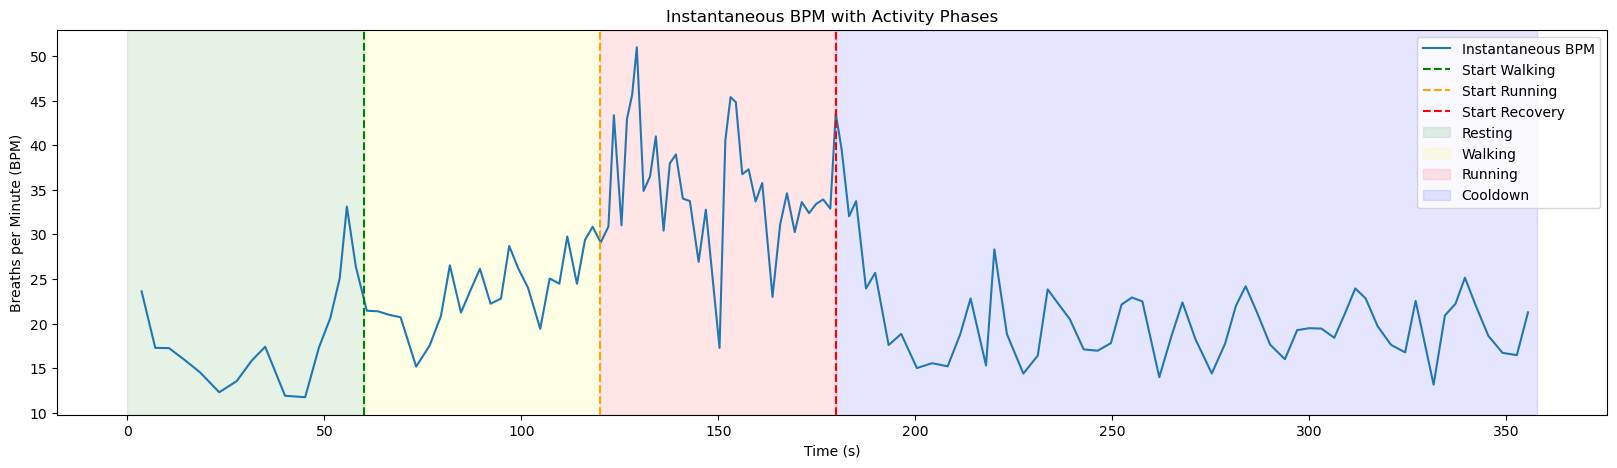

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load your data
time = df_blom["time"]
co2_signal = df_blom["CO2"]

# Detect Peaks
prominence_value = 1000  # Tune if necessary
peaks, _ = find_peaks(co2_signal, distance=20, prominence=prominence_value)

# Define phase change times (seconds)
start_walking_time = 60  # Resting ends, walking starts
start_running_time = 120  # Walking ends, running starts
start_recovery_time = 180  # Running ends, cooldown starts
# After that: recovery/cooldown until end

# --- Plot CO₂ Signal with Peaks and Phases ---
plt.figure(figsize=(20, 5))
plt.plot(time, co2_signal, label='CO₂ Signal')
plt.plot(time.iloc[peaks], co2_signal.iloc[peaks], "x", label="Detected Peaks")

# Add vertical lines for phase changes
plt.axvline(x=start_walking_time, color='green', linestyle='--', label='Start Walking')
plt.axvline(x=start_running_time, color='orange', linestyle='--', label='Start Running')
plt.axvline(x=start_recovery_time, color='red', linestyle='--', label='Start Recovery')

# Add shaded regions for phases
plt.axvspan(time.iloc[0], start_walking_time, color='green', alpha=0.1, label='Resting')
plt.axvspan(start_walking_time, start_running_time, color='yellow', alpha=0.1, label='Walking')
plt.axvspan(start_running_time, start_recovery_time, color='red', alpha=0.1, label='Running')
plt.axvspan(start_recovery_time, time.iloc[-1], color='blue', alpha=0.1, label='Cooldown')

# Labels and Title
plt.xlabel('Time (s)')
plt.ylabel('CO₂ concentration')
plt.title('CO₂ Signal with Activity Phases and Detected Breaths')
plt.legend()
plt.show()

# --- Global BPM Calculation ---
total_time_minutes = (time.iloc[-1] - time.iloc[0]) / 60
total_breaths = len(peaks)
bpm_global = total_breaths / total_time_minutes
print(f"Global BPM: {bpm_global:.2f}")

# --- Instantaneous BPM Calculation ---
peak_times = time.iloc[peaks].values
intervals_sec = np.diff(peak_times)
instantaneous_bpm = 60 / intervals_sec

# Plot Instantaneous BPM
plt.figure(figsize=(20,5))
plt.plot(peak_times[1:], instantaneous_bpm, label="Instantaneous BPM")

# Add vertical lines again
plt.axvline(x=start_walking_time, color='green', linestyle='--', label='Start Walking')
plt.axvline(x=start_running_time, color='orange', linestyle='--', label='Start Running')
plt.axvline(x=start_recovery_time, color='red', linestyle='--', label='Start Recovery')

# Shade again
plt.axvspan(time.iloc[0], start_walking_time, color='green', alpha=0.1, label='Resting')
plt.axvspan(start_walking_time, start_running_time, color='yellow', alpha=0.1, label='Walking')
plt.axvspan(start_running_time, start_recovery_time, color='red', alpha=0.1, label='Running')
plt.axvspan(start_recovery_time, time.iloc[-1], color='blue', alpha=0.1, label='Cooldown')

plt.xlabel('Time (s)')
plt.ylabel('Breaths per Minute (BPM)')
plt.title('Instantaneous BPM with Activity Phases')
plt.legend()
plt.show()

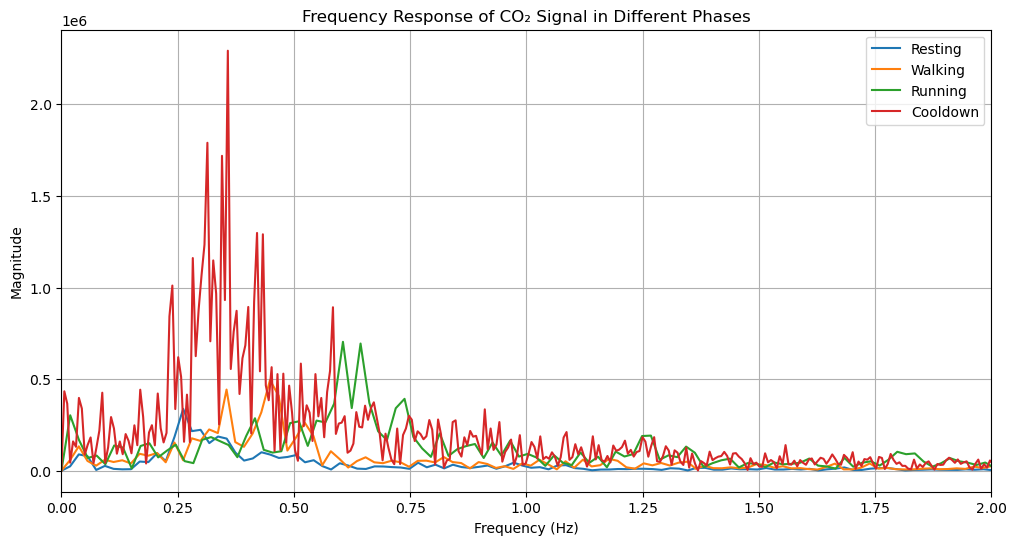

In [194]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
sampling_rate = 20  # 20 Hz
n = len(co2_signal)
total_time = time.iloc[-1] - time.iloc[0]

# Define phase change times (seconds)
start_walking_time = 60
start_running_time = 120
start_recovery_time = 180

# Slice signals
rest_mask = (time >= time.iloc[0]) & (time < start_walking_time)
walk_mask = (time >= start_walking_time) & (time < start_running_time)
run_mask = (time >= start_running_time) & (time < start_recovery_time)
cooldown_mask = (time >= start_recovery_time)

# Helper function: FFT and plot
def plot_frequency_response(signal, phase_name):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/sampling_rate)  # only positive frequencies
    fft_magnitude = np.abs(np.fft.rfft(signal - np.mean(signal)))  # remove DC offset (zero-mean)

    plt.plot(freq, fft_magnitude, label=phase_name)

# Plot frequency responses
plt.figure(figsize=(12, 6))

# Plot for each phase
plot_frequency_response(co2_signal[rest_mask], "Resting")
plot_frequency_response(co2_signal[walk_mask], "Walking")
plot_frequency_response(co2_signal[run_mask], "Running")
plot_frequency_response(co2_signal[cooldown_mask], "Cooldown")

# Plot settings
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Response of CO₂ Signal in Different Phases')
plt.legend()
plt.grid(True)
plt.xlim(0, 2)  # Breath signals are low frequency (0–2 Hz max typically)
plt.show()